# **Irene Dovichi** 
## Midterm 3 - Assignment 3
Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

## Dataset Loading

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)

In [3]:
# Keep only Date, Time, C6H6, and PT08.* columns
df = df[['Date', 'Time', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
df.head()

,Date,Time,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,10/03/2004,18.00.00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0
1,10/03/2004,19.00.00,9.4,1292.0,955.0,1174.0,1559.0,972.0
2,10/03/2004,20.00.00,9.0,1402.0,939.0,1140.0,1555.0,1074.0
3,10/03/2004,21.00.00,9.2,1376.0,948.0,1092.0,1584.0,1203.0
4,10/03/2004,22.00.00,6.5,1272.0,836.0,1205.0,1490.0,1110.0


In [4]:
df.isna().sum()

Date             114
Time             114
C6H6(GT)         480
PT08.S1(CO)      480
PT08.S2(NMHC)    480
PT08.S3(NOx)     480
PT08.S4(NO2)     480
PT08.S5(O3)      480
dtype: int64

In [5]:
# Drop rows with nan values and reset index
df = df.dropna()
df = df.reset_index(drop=True)
df.isna().sum()

Date             0
Time             0
C6H6(GT)         0
PT08.S1(CO)      0
PT08.S2(NMHC)    0
PT08.S3(NOx)     0
PT08.S4(NO2)     0
PT08.S5(O3)      0
dtype: int64

In [6]:
df.shape

(8991, 8)

In [7]:
# Combine Date and Time columns into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df = df.drop(columns=['Date', 'Time'])
df.insert(0, 'DateTime', df.pop('DateTime'))

# We notice that df is ordered by DateTime since the min is the first row and the max is the last row
df['DateTime'].min(), df['DateTime'].max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2005-04-04 14:00:00'))

### Train/Test Split
Since the whole dataset covers more or less a year, we will inevitably have in the test set some months that weren't present in the train. Therefore, I decided to make a basic 80/20 split for the train/test and then for the train/val. The only precaution I had was not to mix the instances to maintain temporal sequentiality, and I made sure that the sets did not split one day.

In [8]:
# calculate 80% of length of df
train_size = int(len(df) * 0.8)
train_size

7192

In [9]:
df.iloc[7189:7194]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
7189,2005-01-15 23:00:00,11.1,1231.0,1017.0,655.0,1207.0,1414.0
7190,2005-01-16 00:00:00,13.6,1289.0,1104.0,623.0,1257.0,1499.0
7191,2005-01-16 01:00:00,9.8,1166.0,970.0,705.0,1136.0,1306.0
7192,2005-01-16 02:00:00,7.6,1062.0,884.0,748.0,1062.0,1172.0
7193,2005-01-16 03:00:00,6.0,1028.0,813.0,794.0,1019.0,1076.0


We can notice that choosing instance 7189 as the last for the train will give approximately the 80% of the data as train data, and we avoid to stop in the middle of measurements for a specific day

In [10]:
train_start_date = df['DateTime'].iloc[0]
train_end_date = df['DateTime'].iloc[7189]

test_start_date = df['DateTime'].iloc[7190]
test_end_date = df['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
test = df[(df['DateTime'] >= test_start_date) & (df['DateTime'] <= test_end_date)]

In [11]:
# calculate 80% of length of train
train_size = int(len(train) * 0.8)
train_size

5752

In [12]:
train.iloc[5759:5764]

,DateTime,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
5759,2004-11-11 21:00:00,16.8,1207.0,1203.0,625.0,1570.0,1251.0
5760,2004-11-11 22:00:00,4.8,904.0,754.0,930.0,1172.0,805.0
5761,2004-11-11 23:00:00,4.0,900.0,711.0,975.0,1153.0,736.0
5762,2004-11-12 00:00:00,4.5,932.0,740.0,926.0,1180.0,774.0
5763,2004-11-12 01:00:00,5.4,968.0,785.0,872.0,1209.0,826.0


In [13]:
train_start_date = train['DateTime'].iloc[0]
train_end_date = train['DateTime'].iloc[5761]

val_start_date = train['DateTime'].iloc[5762]
val_end_date = train['DateTime'].iloc[-1]

train = df[(df['DateTime'] >= train_start_date) & (df['DateTime'] <= train_end_date)]
val = df[(df['DateTime'] >= val_start_date) & (df['DateTime'] <= val_end_date)]

In [14]:
# just a check that we have the correct number of instances
print(f'Wanted instances for train set: {int(len(df) * 0.8 * 0.8)} --> Actual instances: {len(train)}\n'
      f'Wanted instances for val set: {int(len(df) * 0.8 * 0.2)} --> Actual instances: {len(val)}\n'
      f'Wanted instances for test set: {int(len(df) * 0.2)} --> Actual instances: {len(test)}')

Wanted instances for train set: 5754 --> Actual instances: 5762
Wanted instances for val set: 1438 --> Actual instances: 1428
Wanted instances for test set: 1798 --> Actual instances: 1801


In [15]:
X_train = train[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_train = train['C6H6(GT)']

X_val = val[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_val = val['C6H6(GT)']

X_test = test[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
y_test = test['C6H6(GT)']

In [16]:
#TODO: see if NOT having the precaution of keeping a day into a set affects the performances

### Scaling
Concerning the scaling, I decided to use MinMaxScaler() in order to keep the features in a range of [0,1] but keeping their distributions.

In [17]:
# Scale X values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Scale y values
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

In [18]:
# TODO: ha senso scalare anche le y?

### Reshaping
I am going to use a LSTM layer first, which requires the data to be in the form: `[samples, time steps, features]`.

In [19]:
# TODO: spiegare cosa sono timesteps

In [20]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Model Selection
recap della prossima sezione

### Vanilla LSTM Model

In [142]:
# Vanilla LSTM model: 1 layer with 50 units
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(10, activation='relu', return_sequences=True))  
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  

print(model.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, 1, 10)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1, 1)           │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Training Phase

In [143]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - loss: 0.0300 - val_loss: 0.0125
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.0075 - val_loss: 0.0034
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0016 - val_loss: 0.0027
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.0010 - val_loss: 0.0020
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 9.0665e-04 - val_loss: 0.0018
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 8.2110e-04 - val_loss: 0.0017
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 7.4470e-04 - val_loss: 0.0015
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 6.7444e-04 - val_loss: 0.0014
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 6.0984e-04 - val_loss: 0.0013

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 108.4201
Test Loss: 100.33576965332031



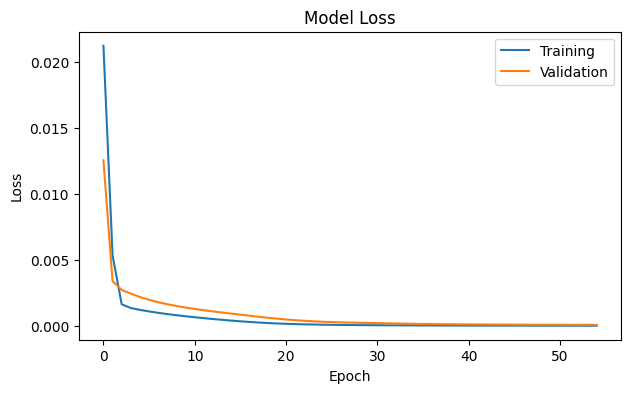

In [144]:
# Print test loss and accuracy
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(7, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [145]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_test.shape, y_pred.shape

In [29]:
y_test = y_test.values.reshape(-1, 1)

In [147]:
# compute mse between y_test and y_pred 
mse = mean_squared_error(y_test, y_pred)

print(f'MSE between y_test and y_pred: {mse}')

MSE between y_test and y_pred: 0.09076442481729508


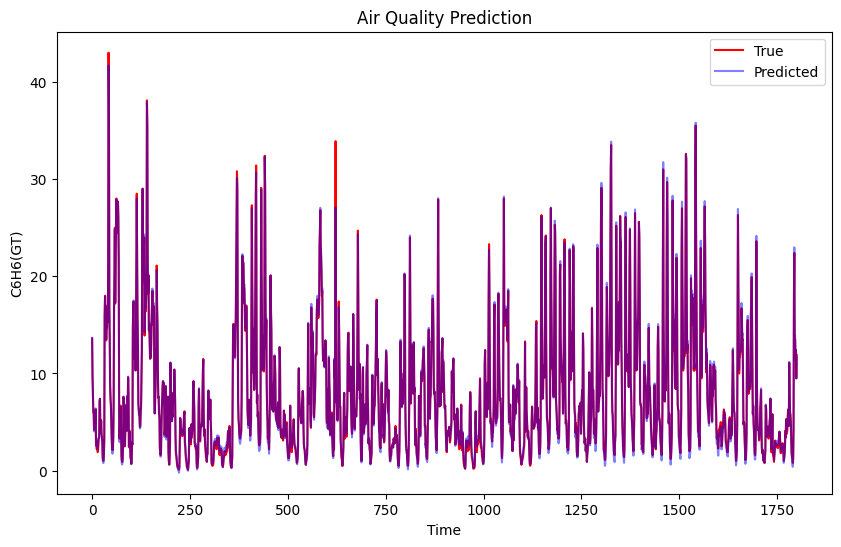

In [148]:
# plot y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

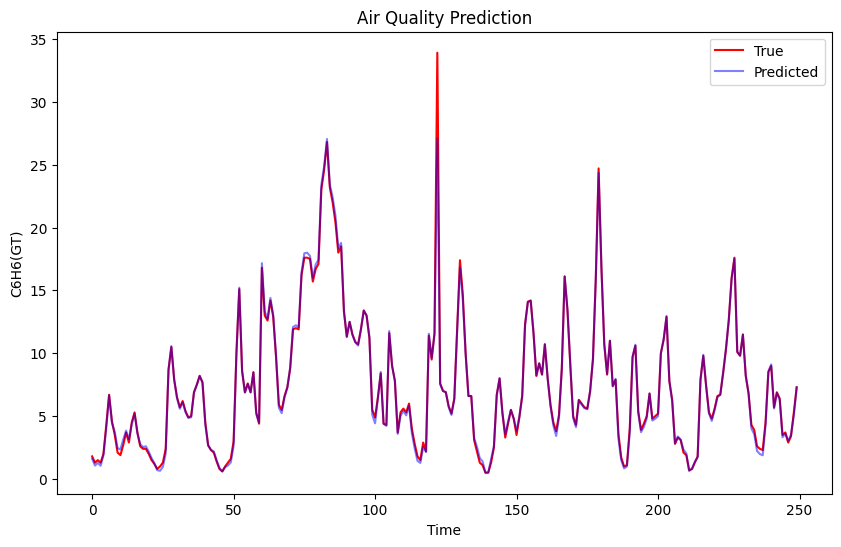

In [149]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

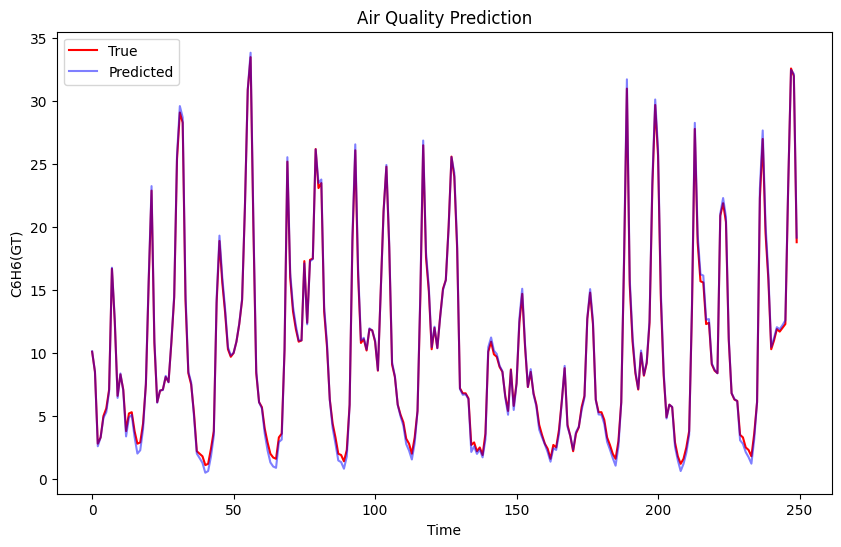

In [151]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[1270:1520], color='red', label='True')
plt.plot(y_pred[1270:1520], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

### Stacked LSTM Model
Let's try with a stacked LSTM model

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(32, activation='relu', return_sequences=True))  
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dense(1))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

print(model.summary())

#### Training Phase

In [152]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), shuffle=False, callbacks=[early_stopping])

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0292 - val_loss: 0.0033
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 9.4134e-04 - val_loss: 0.0011
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 7.9952e-04 - val_loss: 9.9806e-04
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 6.6769e-04 - val_loss: 8.6428e-04
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 5.4291e-04 - val_loss: 7.3008e-04
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 4.2095e-04 - val_lo

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 108.3956
Test Loss: 100.32257080078125



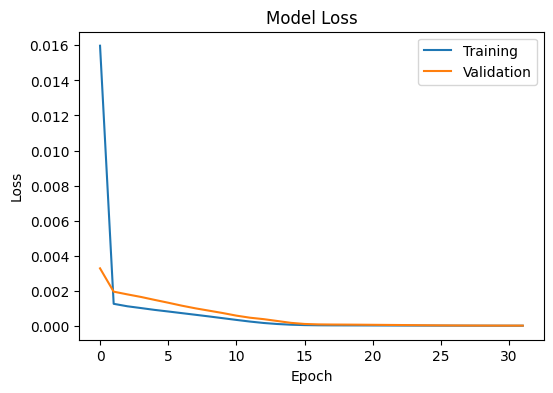

In [153]:
# Print test loss and accuracy
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}\n')

history = history.history

# Plot training & validation loss 
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Predictions

In [154]:
# predict y values
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [155]:
# compute mse between y_test and y_pred 
mse = mean_squared_error(y_test, y_pred)

print(f'MSE between y_test and y_pred: {mse}')

MSE between y_test and y_pred: 0.06767095970705027


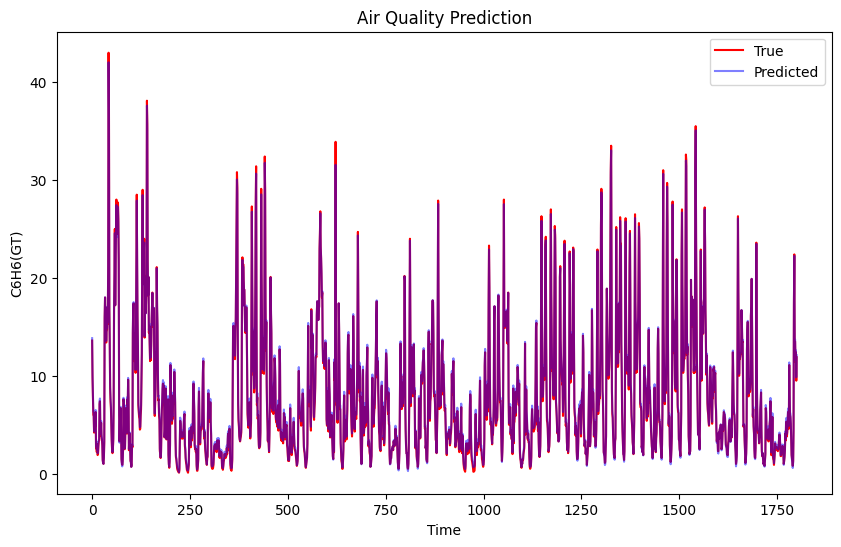

In [156]:
# plot y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='red', label='True')
plt.plot(y_pred, color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

We can notice that the the pick between times 100-150 is now predicted pretty well, better with respect to the previous (vanilla) model!

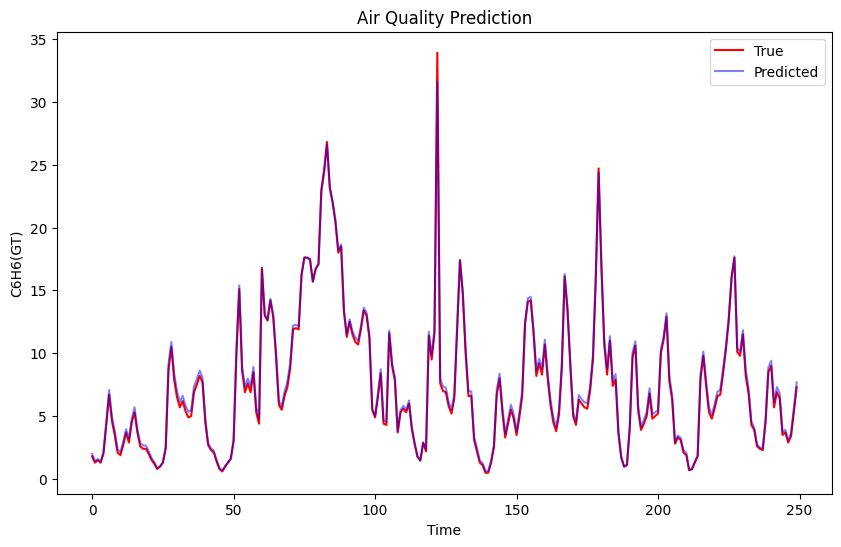

In [157]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[500:750], color='red', label='True')
plt.plot(y_pred[500:750], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

Moreover, the predictions are better also between times 1250-1750. In the vanilla model we could notice that the predictions were lower than the true values

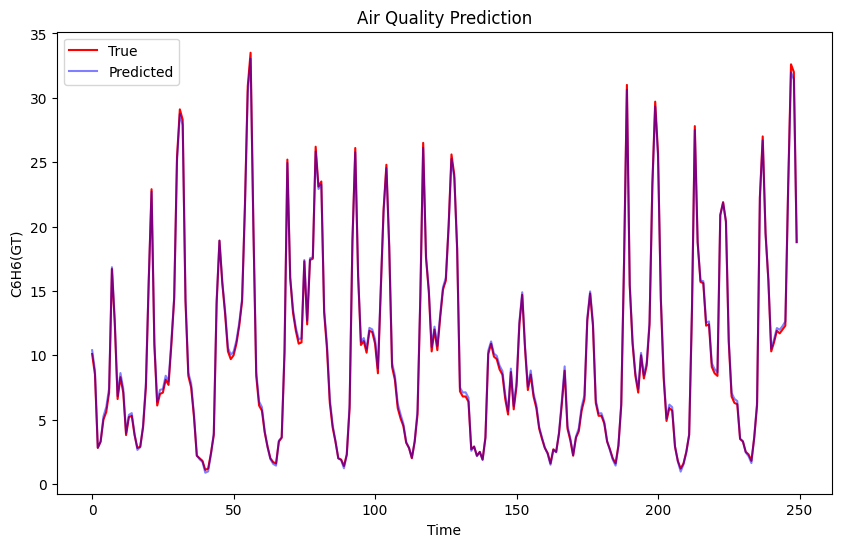

In [158]:
# plot a zoomed-in version of the plot above
plt.figure(figsize=(10, 6))
plt.plot(y_test[1270:1520], color='red', label='True')
plt.plot(y_pred[1270:1520], color='blue', label='Predicted', alpha=0.5)
plt.title('Air Quality Prediction')
plt.ylabel('C6H6(GT)')
plt.xlabel('Time')
plt.legend()
plt.show()

# !!! Another model: Convolutional or GRU
confront with lstm

## One-step ahead Model

In [159]:
X_train.shape, X_val.shape, X_test.shape

((5762, 1, 5), (1428, 1, 5), (1801, 1, 5))

## Personal Considerations

In [ ]:
# il dropout nel primo modello rendeva le performances peggiori: forse perchè il modello era troppo semplice e il dropout lo rendeva ancora più semplice